Notebook for psf_maglim depth of cell-based coadds.

## Load in imports and data

Last working weekly: w2024_34

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

# interpolation mask threshold
import lsst.geom as geom

Confirm which version of packages are setup on the notebook environment.

In [2]:
# import lsst.pipe.tasks, lsst.drp.tasks, lsst.cell_coadds
# print(lsst.pipe.tasks.__file__)
# print(lsst.drp.tasks.__file__)
# print(lsst.cell_coadds.__file__)

In [3]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508' # updated patch 61 collection
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

Patches to choose from: [37, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 60, 61, 62, 63, 67, 83, 84]

In [4]:
patch = 50

In [5]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [6]:
# stitch_coadd = coadd.stitch() # fails with empty cells
explode_coadd = coadd.explode()

In [7]:
cell_list_filled = list(coadd.cells.keys())

In [8]:
cell_list = []
cells_filled = [False] * 484

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

In [9]:
# example on how to use equivalent of np.where on lists
# cell_list_test = [cell_list[index] for index, val in enumerate(cells_filled) if val == True]

In [10]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [11]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.zeros([22,22])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [12]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## Cell Depth

### Cell Depth Methods

Example calculations for values needed to calculate cell cepth.

Image depth equation from https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/healSparseMappingProperties.py#L485

In [13]:
# returns effective PSF area given the PSF stamp image array
def psfArea(psf_im):
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    return numer/denom

In [14]:
# returns the weight (~1/meanVar) of a cell, given the cell object and the statistics settings
def cell_weight(cell, statsCtrl):
    accTask = AssembleCellCoaddTask()
    mask_im = cell.outer.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    return total_weight

In [15]:
# returns the limiting PSF magnitude of each pixel, given the PSF area and cell weight
def mag_lim(psf_area, weights, zp=27, num_sigma=5):
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/weights))
    return maglim

Example on test cell:

In [16]:
depth_cell = coadd.cells[Index2D(x=21,y=21)]
depth_psf_image = depth_cell.psf_image.array
psf_area = psfArea(depth_psf_image)
print("PSF eff. area: ", psf_area)
print("Cell totaled weights: ", cell_weight(depth_cell, statsCtrl))
print("Cell depth: ", np.mean(mag_lim(psf_area, cell_weight(depth_cell, statsCtrl))))

PSF eff. area:  42.591650153416815
Cell totaled weights:  388.155173534826
Cell depth:  26.45217612980335


### Cell Depth 2D Distribution

In [17]:
cell_depths = np.empty([22,22])

for index, cell_index in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 

    cell = coadd.cells[cell_index]
    psf_im = cell.psf_image.array

    psf_area = psfArea(psf_im)
    weight = cell_weight(cell, statsCtrl)
    
    cell_depth = mag_lim(psf_area, weight)

    x_index = cell_index.x
    y_index = cell_index.y
    
    cell_depths[y_index][x_index] = np.mean(cell_depth)

cell_depths = ma.masked_where(cell_depths < 0.1, cell_depths) # TO-DO: remove hard coded condition

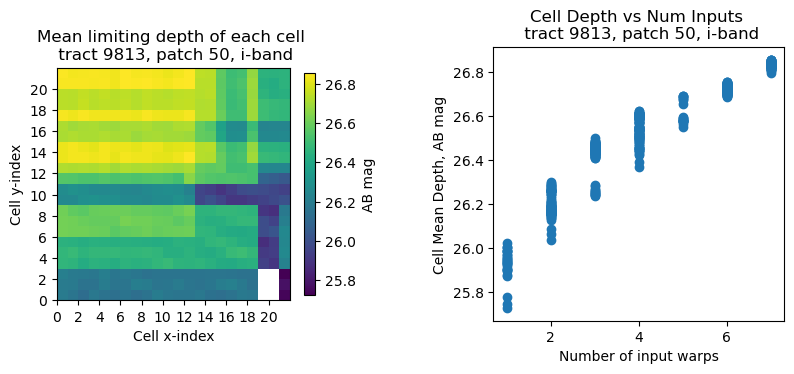

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

depths = axs[0].pcolormesh(cell_depths, 
                        shading='auto', 
                        vmin=ma.min(cell_depths), 
                        vmax=ma.max(cell_depths),)

axs[0].set_title(f"Mean limiting depth of each cell \n tract 9813, patch {patch}, i-band")
axs[0].set_xlabel("Cell x-index")
axs[0].set_ylabel("Cell y-index")
axs[0].set_aspect('equal')
axs[0].set_xticks(np.arange(0, 21, 2))
axs[0].set_yticks(np.arange(0, 21, 2))
fig.colorbar(depths, ax=axs[0], cmap='viridis', shrink=0.3, label='AB mag')

depths = axs[1].scatter(inputs_list.flatten(), cell_depths)

# a rough estimate of the theoretical improvement in depth
xs = np.linspace(1, 7, 1000)
ys = 1.25*np.log10(xs)+25.8
#log_funtion = axs[1].plot(xs, ys)

axs[1].set_title(f"Cell Depth vs Num Inputs \n tract 9813, patch {patch}, i-band")
axs[1].set_aspect(12)
axs[1].set_xlabel("Number of input warps")
axs[1].set_ylabel("Cell Mean Depth, AB mag")
axs[1].set_aspect(5)

Fortunately, the limiting depth seems to improve as number of input images increases. This should be tested on a wider range of cells.